In [52]:
# This notebook will run various models on the data to predict a more accurate value of the home.
# Feature engineering techniques will be employed.
# Many models will be built and compared to find the best model for the job.

In [53]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [54]:
# https://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    # def fit(self,X,y=None):
    #     return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        # return self.fit(X,y).transform(X)
        return self.transform(X)
    
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [55]:
'''
Read in csv files.
'''

df_forSale = pd.read_csv('cleaned_forSale_data.csv', index_col=0)
df_recentlySold = pd.read_csv('cleaned_recentlySold_data.csv', index_col=0)

df_recentlySold['dateSold'] = pd.to_datetime(df_recentlySold['dateSoldString'])
df_recentlySold.drop('dateSoldString', axis=1, inplace=True)

modelColumns_recentlySold = ['daysOnZillow', 'price/sqft', 'zipcode', 'yearBuilt', 'bedrooms', 'bathrooms', 'livingAreaValue',
                             'lotAreaValue', 'zestimate', 'favoriteCount', 'pageViewCount', 'resoFacts.associationFee',
                             'listingSubType.isForeclosure', 'resoFacts.isSeniorCommunity', 'priceOutlier', 'price']

modelColumns_forSale = ['daysOnZillow', 'listPrice', 'price/sqft', 'zipcode', 'yearBuilt', 'bedrooms', 'bathrooms', 'livingAreaValue',
                        'lotAreaValue', 'zestimate', 'favoriteCount', 'pageViewCount', 'resoFacts.associationFee',
                        'listingSubType.isForeclosure', 'resoFacts.isSeniorCommunity']

In [56]:
# Make sure all numerical data is of type numerical.

# print(df_recentlySold.info())
# print('')
# print(df_forSale.info())

One of the most asked questions in data science/ML: Do you apply feature scaling before or after splitting your data?

Answer: Only one answer. ALWAYS AFTER SPLITTING DATA!! --  You need the test set to be a completely new, unseen data set. Feature scaling calculates means/std.dev's and so it must be done after the split to keep the two sets seperate. Key term: Information Leakage.

In [57]:
'''
Prep data for model training

xxxxx_REMOVE OUTLIERS FROM DATA BEFORE PROCEEDING_xxxxx
'''

# Select only the columns needed for training/testing, apply OneHotEncoding, and convert to Numpy array for training.
modelData_recentlySold = df_recentlySold[modelColumns_recentlySold]
modelData_recentlySold = modelData_recentlySold.loc[modelData_recentlySold['priceOutlier']==0]
X_recentlySold = modelData_recentlySold.columns.difference(['price'])
X_recentlySold = modelData_recentlySold[X_recentlySold]
X_recentlySold = np.array(MultiColumnLabelEncoder(columns = ['listingSubType.isForeclosure','resoFacts.isSeniorCommunity'])
                          .fit_transform(X_recentlySold))
y_recentlySold = np.array(modelData_recentlySold[['price']])
y_recentlySold = y_recentlySold.ravel()

modelData_forSale = df_forSale[modelColumns_forSale]
X_forSale = np.array(MultiColumnLabelEncoder(columns = ['listingSubType.isForeclosure','resoFacts.isSeniorCommunity'])
                     .fit_transform(modelData_forSale))

# Split the data: recentlySold = 80% train/20% test. forSale = 100% test
X_train, X_test, y_train, y_test = train_test_split(X_recentlySold, y_recentlySold, test_size=0.2, random_state=35)

# Feature Scaling
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Index(['bathrooms', 'bedrooms', 'daysOnZillow', 'favoriteCount',
       'listingSubType.isForeclosure', 'livingAreaValue', 'lotAreaValue',
       'pageViewCount', 'price/sqft', 'priceOutlier',
       'resoFacts.associationFee', 'resoFacts.isSeniorCommunity', 'yearBuilt',
       'zestimate', 'zipcode'],
      dtype='object')


# Build, Train, Test, and Validate Models on recentlySold Dataset

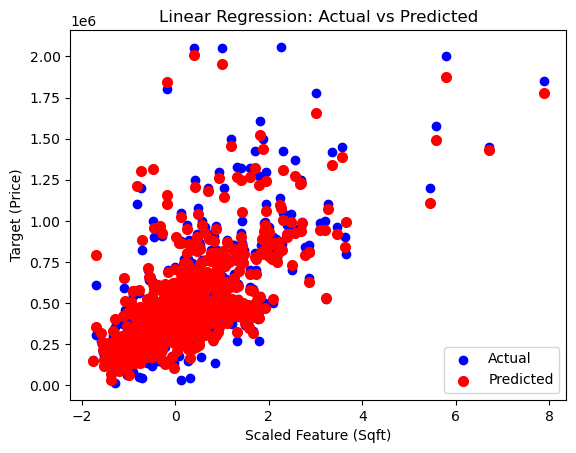

Tuned Hyperparameters :(Best Parameters)  {'fit_intercept': True}
Training R_Squared: 0.9775487937312347

Testing R_Squared:  0.9711536586212194
MSE:  1997026529.320156
RMSE:  44688.102771544865
MAE:  17314.447584855276
MAPE:  6.611886952452299
Adjusted R2 Score:  0.9707419601239009



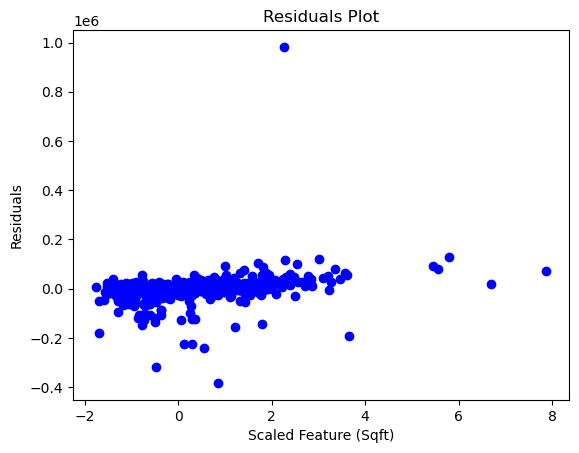

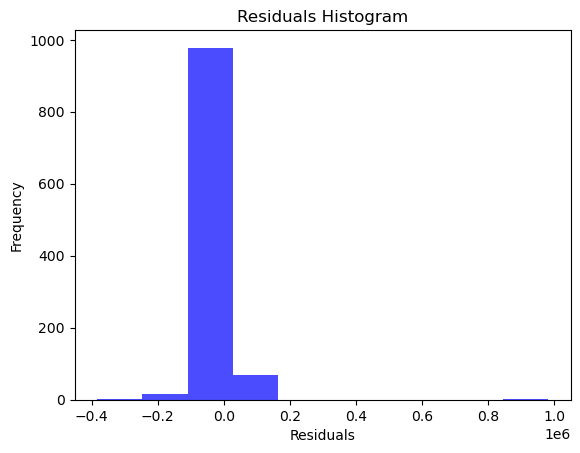

In [58]:
'''
Build, train, test, and validate a LinearRegression() model
'''

# Build, train, and test the model
parameters = {'fit_intercept':[True, False]}
lr = LinearRegression()
linReg = GridSearchCV(estimator=lr, param_grid=parameters, cv=10)
linReg.fit(X_train, y_train)
y_pred = linReg.predict(X_test)

# Visualize the results
plt.scatter(X_test[:,5], y_test, color='blue', label='Actual')
plt.scatter(X_test[:,5], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Target (Price)')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Validate the model
print("Tuned Hyperparameters :(Best Parameters) ",linReg.best_params_)
print("Training R_Squared:",linReg.best_score_) # this value is the best score on TRAINING data!!
print('')

score_lr = linReg.score(X_test, y_test) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
score_lr = mean_squared_error(y_test, y_pred)
print("MSE: ", score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')

# Plot errors
residuals = y_test - y_pred
# Scatter plot of residuals
plt.scatter(X_test[:, 5], residuals, color='blue', marker='o')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

del residuals

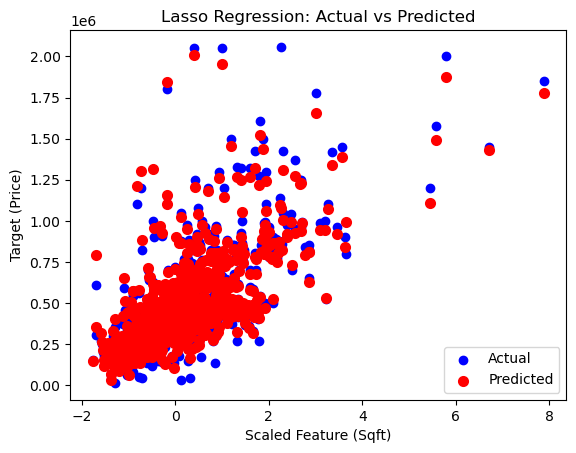

Tuned Hyperparameters :(Best Parameters)  {'alpha': 0.1, 'fit_intercept': True}
Training R_Squared: 0.9775488293807075

Testing R_Squared:  0.9711536003494892
MSE:  1997030563.4605534
RMSE:  44688.14790814846
MAE:  17314.314887708024
MAPE:  6.611865270725168
Adjusted R2 Score:  0.9707419010205095



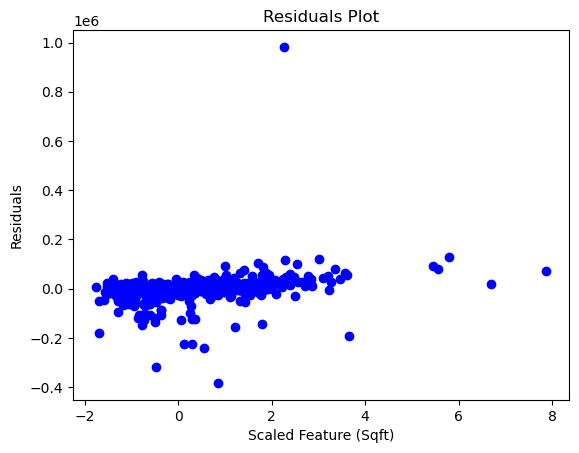

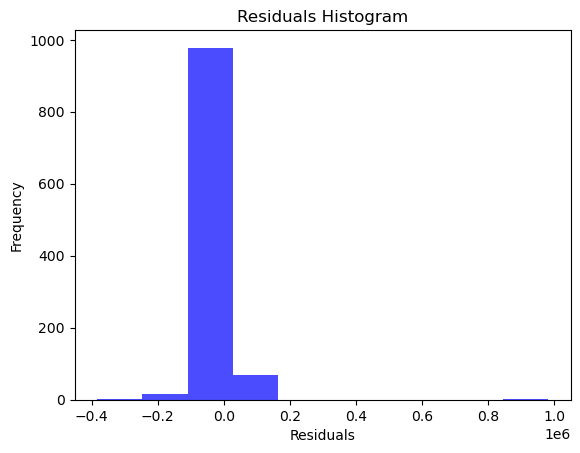

In [59]:
'''
Build, train, test, and validate a LassoRegression() model
'''

# Build, train, and test the model
parameters = {'fit_intercept':[True, False], 'alpha':[0.1, 0.01]}
la = Lasso()
laReg = GridSearchCV(estimator=la, param_grid=parameters, cv=10)
laReg.fit(X_train, y_train)
y_pred = laReg.predict(X_test)

# Visualize the results
plt.scatter(X_test[:,5], y_test, color='blue', label='Actual')
plt.scatter(X_test[:,5], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Target (Price)')
plt.title('Lasso Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Validate the model
print("Tuned Hyperparameters :(Best Parameters) ",laReg.best_params_)
print("Training R_Squared:",laReg.best_score_) # this value is the best score on TRAINING data!!
print('')

score_lr = laReg.score(X_test, y_test) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
score_lr = mean_squared_error(y_test, y_pred)
print("MSE: ", score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')

# Plot errors
residuals = np.transpose(y_test) - y_pred
# Scatter plot of residuals
plt.scatter(X_test[:, 5], residuals, color='blue', marker='o')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

residuals = np.transpose(residuals)
# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

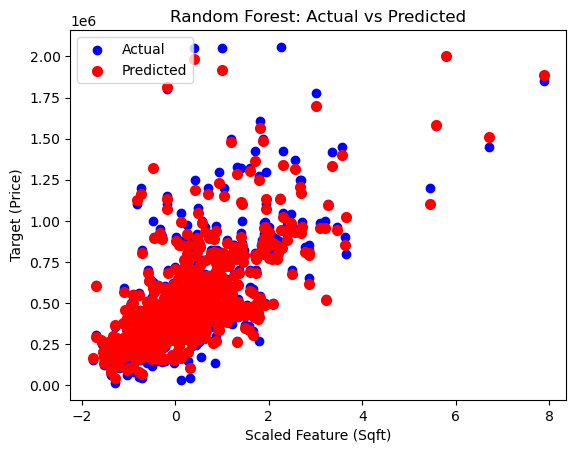

Tuned Hyperparameters: (Best Parameters)  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Estimator:  RandomForestRegressor(max_depth=10, n_estimators=50)
Training R_Squared: -32823.64948619998

Testing R_Squared:  -45756.3358566268
MSE:  2093642271.0244315
RMSE:  45756.3358566268
MAE:  14152.820801597269
MAPE:  4.501026873114757
Adjusted R2 Score:  0.9693264620411564



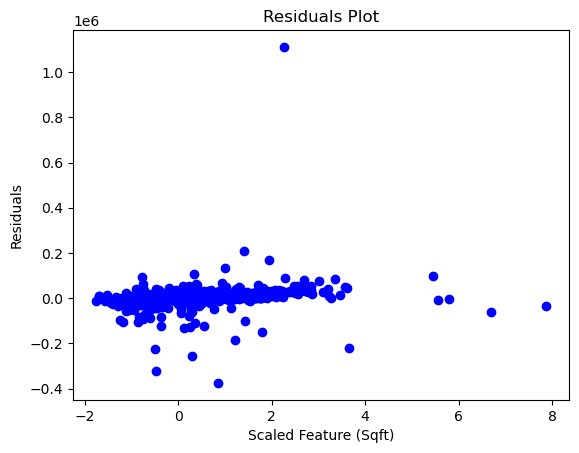

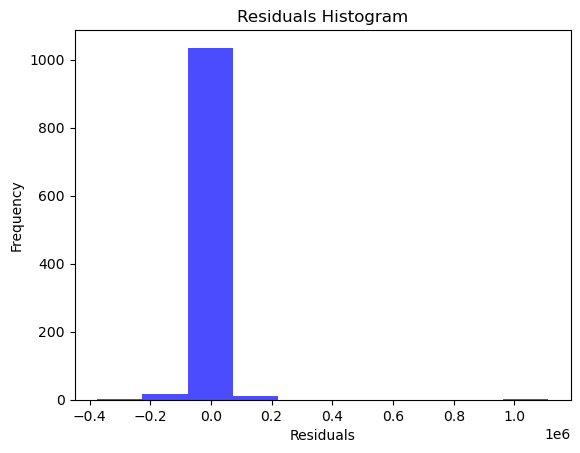

In [60]:
'''
Build, train, test, and validate a RandomForest() model
'''

# Build, train, and test the model
parameters = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# randFor = RandomForestRegressor(n_estimators=150, random_state=42)
rf = RandomForestRegressor()
randFor = GridSearchCV(estimator=rf, param_grid=parameters, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
randFor.fit(X_train, y_train)
y_pred = randFor.predict(X_test)

# Visualize the results
plt.scatter(X_test[:,5], y_test, color='blue', label='Actual')
plt.scatter(X_test[:,5], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Target (Price)')
plt.title('Random Forest: Actual vs Predicted')
plt.legend()
plt.show()

df_results = pd.DataFrame()

# Validate the model
print("Tuned Hyperparameters: (Best Parameters) ",randFor.best_params_)
print("Best Estimator: ",randFor.best_estimator_)
print("Training R_Squared:",randFor.best_score_) # this value is the best score on TRAINING data!!
print('')

score_lr = randFor.score(X_test, y_test) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
score_lr = mean_squared_error(y_test, y_pred)
print("MSE: ", score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')

# Plot errors
residuals = np.transpose(y_test) - y_pred
# Scatter plot of residuals
plt.scatter(X_test[:, 5], residuals, color='blue', marker='o')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

residuals = np.transpose(residuals)
# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

In [61]:
'''
Execute best model on forSale data
'''


'\nExecute best model on forSale data\n'